In [1]:
from src.eeg import struct
from src.core import REc
from src.tools import exclude_from_sz_cm
from src.game import classify_epochs, evaluate_nodes, check_until

from itertools import combinations
from os import listdir, makedirs
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
main_folder = "/home/kivi/gdrive/epigame-folder/"

path_cm = main_folder + "connectivity_matrices/" 

In [3]:
woi = input("Time window:\n 1. Non-seizure (baseline)\n 2. Pre-seizure (5 min prior to seizure)\n 3. Pre-seizure (4 min prior to seizure)\n 4. Pre-seizure (3 min prior to seizure)\n 5. Pre-seizure (2 min prior to seizure)\n 6. Pre-seizure (1 min prior to seizure)\n 7. Transition to seizure (1 min interval)\n 8. Transition to seizure (2 min interval)\n 9. Transition to seizure (60% seizure length interval)\n 10. Seizure\n Indicate a number: ")

woi_code = {'1':"baseline", '2':"preseizure5", '3':"preseizure4", '4':"preseizure3", '5':"preseizure2", '6':"preseizure1", '7':"transition1", '8':"transition2", '9':"transition60", '10':"seizure"}

In [4]:
max_net_size = 18

In [5]:
path_net = main_folder + "selected_network/"
makedirs(path_net, exist_ok=True)


--------------------------------------------------------------

Processing...
Connectivity matrices of ASJ-preseizure5-PLI-(0,4).prep
Number of nodes = 98

Nodes: ['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4

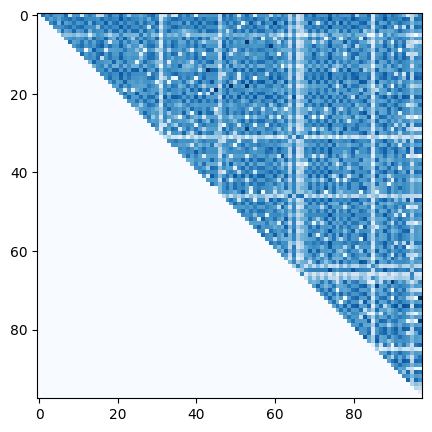

[[0.    0.76  0.612 ... 0.292 0.448 0.704]
 [0.    0.    0.68  ... 0.312 0.752 0.72 ]
 [0.    0.    0.    ... 0.46  0.604 0.572]
 ...
 [0.    0.    0.    ... 0.    0.292 0.26 ]
 [0.    0.    0.    ... 0.    0.    0.112]
 [0.    0.    0.    ... 0.    0.    0.   ]]

Processing node combinations...
4753 finished
Best node pair: [((4, 50), 'P10-P11<->Q9-Q10', array([0.4       , 0.4       , 0.4       , 0.4       , 0.5       ,
       0.5       , 0.7       , 0.4       , 0.7       , 0.5       ,
       0.9       , 0.4       , 0.7       , 0.6       , 0.4       ,
       0.4       , 0.7       , 0.5       , 0.4       , 0.4       ,
       0.6       , 0.6       , 0.44444444, 0.44444444]), 0.6973991031390135)]
Best score = 0.6973991031390135

Checking networks with 3 nodes...
Searching for the index of the last best network...
Net = [((4, 50), 'P10-P11<->Q9-Q10', array([0.4       , 0.4       , 0.4       , 0.4       , 0.5       ,
       0.5       , 0.7       , 0.4       , 0.7       , 0.5       ,
      

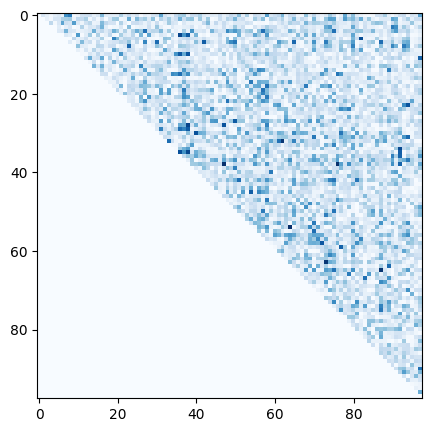

[[0.    0.116 0.064 ... 0.128 0.104 0.412]
 [0.    0.    0.056 ... 0.064 0.172 0.184]
 [0.    0.    0.    ... 0.296 0.072 0.052]
 ...
 [0.    0.    0.    ... 0.    0.06  0.044]
 [0.    0.    0.    ... 0.    0.    0.384]
 [0.    0.    0.    ... 0.    0.    0.   ]]

Processing node combinations...
4753 finished
Best node pair: [((45, 47), 'Q1-Q2<->Q3-Q4', array([0.6       , 0.5       , 0.7       , 0.5       , 0.7       ,
       0.7       , 0.7       , 0.5       , 0.6       , 0.5       ,
       0.6       , 1.        , 0.7       , 0.6       , 0.8       ,
       0.5       , 0.7       , 0.7       , 0.8       , 0.8       ,
       0.8       , 0.6       , 0.55555556, 0.55555556]), 0.7637906647807639)]
Best score = 0.7637906647807639

Checking networks with 3 nodes...
Searching for the index of the last best network...
Net = [((45, 47), 'Q1-Q2<->Q3-Q4', array([0.6       , 0.5       , 0.7       , 0.5       , 0.7       ,
       0.7       , 0.7       , 0.5       , 0.6       , 0.5       ,
       0.6

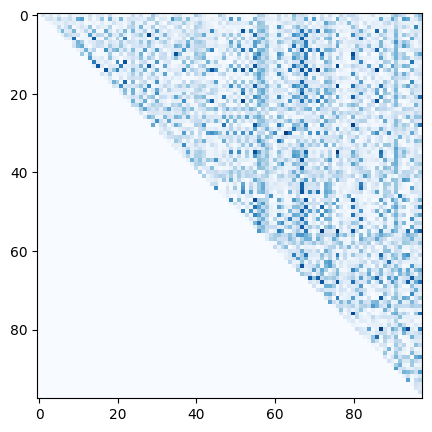

[[0.    0.152 0.052 ... 0.008 0.276 0.428]
 [0.    0.    0.136 ... 0.072 0.148 0.36 ]
 [0.    0.    0.    ... 0.088 0.036 0.124]
 ...
 [0.    0.    0.    ... 0.    0.156 0.12 ]
 [0.    0.    0.    ... 0.    0.    0.2  ]
 [0.    0.    0.    ... 0.    0.    0.   ]]

Processing node combinations...


In [6]:
#TODO: Explain the rec object, how to access the results and the pipeline in the markdown above.

from itertools import combinations
from os import listdir
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import random as rd

for file_cm in listdir(path_cm):
  if file_cm.split("-")[1]==woi_code[woi] and "PLI" in file_cm:

    print("\n--------------------------------------------------------------")
    print("\nProcessing...")

    subject_id = file_cm.split("/")[-1][0:3]
    print("Connectivity matrices of", file_cm)

    cm = REc.load(path_cm + file_cm).data

    nodes = cm.nodes
    node_ids = list(range(len(nodes))) 
    print("Number of nodes =",len(nodes))
    print("\nNodes:", nodes)

    # For subject ASJ, for connectivity analysis using CC and SCR delta (WOI 2-5),
    # the seizure connectivity matrices have an extra channel that was not excluded;
    # The node was excluded from the labels list (nodes), therefore:
    # This block of code excludes the channel "J9-J10", with the index of the channel "J10-J11" in the current labels list.
    if subject_id=="ASJ" and ((file_cm.split("-")[2]=="CC" and "(70,150)" not in file_cm) or (file_cm.split("-")[2]=="SCR" and int(file_cm.split("-")[1][-1]) in [2,3,4,5])):
      mismatch_channel_id = cm.nodes.index("J10-J11")
      print("Mismatched node index:", mismatch_channel_id)
      cm.X = exclude_from_sz_cm(cm.X, mismatch_channel_id)
      print("Check PREP file sets:", list(cm.__dict__))

    print("\nTotal number of epochs =", len(cm.X))
    print("Connectivity matrix shape =", cm.X[0].shape)
    print("All matrices have the same shape:", all([m.shape==(len(nodes),len(nodes)) for m in cm.X]))
    plt.figure(figsize=(5,5))
    plt.imshow(cm.X[-1], cmap='Blues', interpolation='nearest')
    plt.show()
    print(cm.X[-1])

    node_pairs = combinations(node_ids, 2)

    print("\nProcessing node combinations...")

    parallelize = Parallel(n_jobs=-1)(delayed(evaluate_nodes)(pair, nodes, classify_epochs(cm, pair)) for pair in node_pairs)
    base = [p for p in parallelize]

    print(f"{len(base)} finished")

    base.sort(key=lambda x:x[-1], reverse=True)
    best_pair = base[0]
    best_net = [best_pair]
    print(f"Best node pair: {best_net}")

    best_score, net_size, possible_node_groups, test_nets = base[0][-1], 3, base[:], []
    print("Best score =", best_score)

    all_node_groups = {} # This dictionary saves all tested node groups, under a key indicating net_size (number of grouped nodes) 
    all_node_groups[2] = base

    while net_size <= max_net_size:

      all_node_groups[net_size] = []

      print(f"\nChecking networks with {net_size} nodes...")

      head = check_until(possible_node_groups, fall=best_score)
      
      count_node_groups = 0

      # The condition below checks if all tested node groups have the same score (the best score);
      # if this is the case, we stop the process and save the selected network as all possible nodes.
      # We predited that this could occur in the seizure propagation time window, e.g.
      if possible_node_groups[:head] == possible_node_groups: 

        print("All possible networks present the best score.")
        selected_net = nodes
        print(f"\nSelected network: {selected_net} ({len(selected_net)} nodes in total)")

        file_net = file_cm.split(".")[0]
        REc(struct(test_nets=all_node_groups, nodes=selected_net)).save(path_net + f"{file_net}.res")
      
      else:

        # In case there not all, but many network with the best score, the processing time could become impractical;
        # to bypass this, we define a limit of maximally considered number of top networks as the *max_net_size* parameter.
        # (If the selected network is much larger than the actual resection in good outcome patients, the result is useless.)
        # Thus, among the top networks, a number equal to *max_net_size* of randomly picked networks are selected for the next iteration.
        possible_node_groups = possible_node_groups[:head if head>0 else 1]
        if len(possible_node_groups) >= max_net_size: 

          print(f"More than {max_net_size} networks present the best score. Randomly selecting {max_net_size} networks from the pool.")
          possible_node_groups = rd.sample(possible_node_groups, max_net_size)

        for node_group in possible_node_groups:
            # Here, we iterate through the node groups with the highest score, as possibly there are more than one

            for node in node_ids:
              # All possible nodes are added to the group and tested

              if node not in node_group[0]:
                  # Avoiding duplicate nodes

                  test_group = node_group[0] + (node,)

                  # Perform the classification between baseline and WOI epochs, using the support vector machine
                  # Compute the cross-validation scores, using the K-Fold method
                  # Apply the evaluation function to the cross-validation scores
                  eval = evaluate_nodes(test_group, nodes, classify_epochs(cm, test_group))

                  # Store the tested node groups in test_nets list and all_node_groups dictionary, under the net_size key
                  test_nets.append(eval)
                  all_node_groups[net_size].append(eval)

              count_node_groups += 1



        print(f"Tested {count_node_groups} node groups.")

        # Sort the latest networks by their score (indexed -1) and save the best evaluation score
        test_nets.sort(key=lambda x:x[-1], reverse=True)
        all_node_groups[net_size].sort(key=lambda x:x[-1], reverse=True)

        evaluation_score = test_nets[0][-1]

        print(f"Best score for networks of size {net_size} =", evaluation_score)
        print(f"Best network of size {net_size}: {test_nets[0][1]}")

        if evaluation_score >= best_score:
            # If the new score is higher than the previous best score, 
            # update the best score and the possible node groups for the next iteration
            if net_size <= max_net_size:

                best_score = evaluation_score
                print("\nNew best score =", best_score)

                head_i = check_until(test_nets, fall=best_score)
                best_net = test_nets[:head_i if head_i>0 else 1]
                print("\nNew best network =", best_net)

                possible_node_groups = best_net
                test_nets = []
                                
            net_size += 1
            
        else: 
          print("A better network not found.")
          net_size = max_net_size

      selected_net = sorted(set([t for n in best_net for t in n[1].split('<->')]))


      print(f"\nSelected network: {selected_net} ({len(selected_net)} nodes in total)")

      file_net = file_cm.split(".")[0]
      REc(struct(test_nets=all_node_groups, nodes=selected_net)).save(path_net + f"{file_net}.res")